# Import Library

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

# Read The Dataset

In [2]:
fish_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset' 
classes = [i for i in os.listdir(fish_dir) if '.' not in i]                    
print(classes)

['Hourse Mackerel', 'Black Sea Sprat', 'Sea Bass', 'Red Mullet', 'Trout', 'Striped Red Mullet', 'Shrimp', 'Gilt-Head Bream', 'Red Sea Bream']


In [3]:
label = []
path = []

for dir_name, _,filenames in os.walk(fish_dir):                    
    for filename in filenames:                                 
        if os.path.splitext(filename)[-1]=='.png':               # If filename contains .png
            if dir_name.split()[-1]!='GT':                       # If directory doesn't contain GT
                label.append(os.path.split(dir_name)[-1])         # Append the directory name to label 
                path.append(os.path.join(dir_name,filename))     # Append all the png files to path of that directory

data = pd.DataFrame(columns=['path','label'])
data['path']=path
data['label']=label

# Checking the distribution of the dataset

In [4]:
data['label'].value_counts()

label
Hourse Mackerel       1000
Black Sea Sprat       1000
Sea Bass              1000
Red Mullet            1000
Trout                 1000
Striped Red Mullet    1000
Shrimp                1000
Gilt-Head Bream       1000
Red Sea Bream         1000
Name: count, dtype: int64

In [5]:
batch_size = 32 # Grup Sayısı
img_height = 224 # Verilerin Yükseklik değerini belirleme
img_width = 224 # Verilerin Genişlik değerini belirleme

In [6]:
# Prepare data generators with rescaling and validation split
train_datagen = ImageDataGenerator(
    rescale=1./255, # Veri setini yeniden ölçeklendirme
    validation_split=0.2)  # 20% oranında Onaylama Veri Setine bölüyoruz

# Train seti ve Validation seti oluşturmak

In [7]:
train_generator = train_datagen.flow_from_directory(
    directory=fish_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset='training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    directory=fish_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical')

Found 14400 images belonging to 9 classes.
Found 3600 images belonging to 9 classes.


In [8]:
# Get the number of classes
num_classes = len(train_generator.class_indices)

# ANN modeli tanımlamak

In [9]:
model_ann = keras.Sequential([
    layers.InputLayer(input_shape=(img_height, img_width, 3)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'), #512 katmanlı Nöral Ağ oluşturmak 
    
    layers.Dense(256, activation='relu'), # Relu: Negatif değerleri sıfıra çeker

    layers.Dense(128, activation='relu'), #128 katmanlı Nöral Ağ oluşturmak 
    layers.BatchNormalization(),   # Daha hızlı eğitim yapabilmek için
    layers.Dropout(0.5),           # Overfitting'i azaltmak için
    
    
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model_ann.compile(
    optimizer='adam', # Dinamik öğrenme oranı sağlar
    loss='categorical_crossentropy', # [1, 0, 0], [0, 1, 0], [0, 0, 1] gibi veriler için modelin hatasını (Loss) hesaplar
    metrics=['accuracy'])

# Print model summary
model_ann.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    77,070,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,236,745 (294.63 MB)

 Trainable params: 77,236,489 (294.63 MB)

 Non-trainable params: 256 (1.00 KB)

# ANN algoritmasını veri setimiz ile eğittiğimiz alandır 

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# Patience: Eğitimin gelişme göstermemesine olan sabırdır 
# restore_best_weights=True modelin en sağlıklı olduğu duruma geri dönüş sağlamayı sağlar
# Modeli eğitirken Callback ile koruyoruz
history = model_ann.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=15, 
    callbacks=[early_stopping]  # Eğitimi gelişme göstermez ise durdurmak içindir
)


Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


450/450 ━━━━━━━━━━━━━━━━━━━━ 446s 980ms/step - accuracy: 0.2291 - loss: 2.1417 - val_accuracy: 0.3644 - val_loss: 1.7518
Epoch 2/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 468s 1s/step - accuracy: 0.4415 - loss: 1.5038 - val_accuracy: 0.3150 - val_loss: 2.0552
Epoch 3/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 458s 1s/step - accuracy: 0.5258 - loss: 1.2878 - val_accuracy: 0.4472 - val_loss: 1.3631
Epoch 4/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 430s 952ms/step - accuracy: 0.6009 - loss: 1.1039 - val_accuracy: 0.5461 - val_loss: 1.3480
Epoch 5/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 434s 962ms/step - accuracy: 0.6388 - loss: 0.9988 - val_accuracy: 0.6258 - val_loss: 1.0011
Epoch 6/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 429s 950ms/step - accuracy: 0.6943 - loss: 0.8556 - val_accuracy: 0.6014 - val_loss: 1.3075
Epoch 7/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 432s 957ms/step - accuracy: 0.6756 - loss: 0.9423 - val_accuracy: 0.1856 - val_loss: 3.3120
Epoch 8/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 431s 955ms/step - accuracy: 0.5203 - loss: 1.2932 - v

# ANN algoritmasının veri setini ne kadar öğrendiğini denetlemek için ayırdığımız onaylama verileriyle yaptığı test süreci

In [11]:
# Evaluate the model
loss, accuracy = model_ann.evaluate(validation_generator)
print(f'Validation loss: {loss}')
print(f'Validation accuracy: {accuracy}')

113/113 ━━━━━━━━━━━━━━━━━━━━ 46s 409ms/step - accuracy: 0.6366 - loss: 0.9741
Validation loss: 1.0010766983032227
Validation accuracy: 0.6258333325386047


# ANN algoritmasının Epoch başarı (Loss ve Accuracy) değeri için oluşturduğumuz grafiktir

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

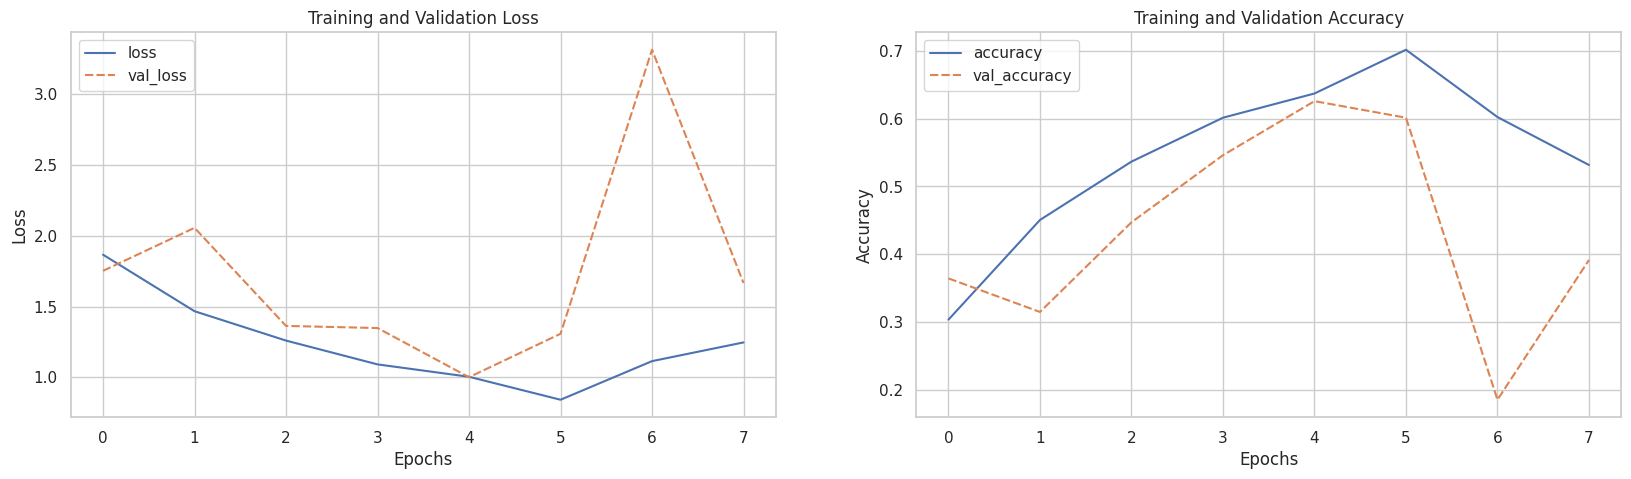

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Eğitim geçmişini DataFrame'e çevir
history_df = pd.DataFrame(history.history)

# Sonsuz (inf) değerleri NaN olarak değiştir
history_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# NaN değerlerini gerekirse doldur veya yok say
history_df.dropna(inplace=True)

# Grafik çizimi
sns.set(style="whitegrid")
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# Loss grafiği
sns.lineplot(data=history_df[['loss', 'val_loss']], ax=ax[0])
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')

# Accuracy grafiği
sns.lineplot(data=history_df[['accuracy', 'val_accuracy']], ax=ax[1])
ax[1].set_title('Training and Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')

plt.show()
